In [1]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
import uproot.models
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/Atmos_Pandora/apc_atmo_repo/Anatree/')
sys.path.append(f'/home/henrique/Documents/Atmos_Pandora/apc_atmo_repo/personal/Henrique/Analysis/pida/')
from anatree_class import Anatree
from PIDA_class import PIDA
from  ana_tools import *
import plotly.graph_objects as go


import mplhep
mplhep.style.use(mplhep.style.ROOT)
plt.rcParams.update({'font.size': 23,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                    #  'figure.figsize': [14,6],
                     })


from pida_functions import *

In [ ]:
def loaddata(path:str, entry_stop=None, forceit=False):
    parquet_path= path.replace(".root", ".parquet")
    if os.path.isfile(parquet_path) and not forceit:
        print(path, 'loaded parquet')
        df = pl.read_parquet(parquet_path)
        return df
    pid = PIDA(path, entry_stop=entry_stop)
    dfs:pl.DataFrame
    dfv:pl.DataFrame
    df:pl.DataFrame

    dfs = pid.dfsingles
    dfv = pid.dfvector
    dfp = pid.dfplanes

    df = dfs.join(dfv, on=selection_events())
    df = df.join(dfp, on=selection_events())
    df.write_parquet(file=parquet_path)
    return df
    
# df = loaddata("data/pida_new_full.root", entry_stop=None, forceit=False)
# df = loaddata("data/pida_visen.root", forceit=True)
# df = pl.scan_parquet("data/pida_new_full.parquet")
df = pl.scan_parquet("data/pida_visen.parquet")
# df = pl.scan_parquet('data/pida_new.parquet')
# df = pl.scan_parquet('data/pida_new.parquet')


Loading single values


100%|██████████| 22/22 [00:17<00:00,  1.27it/s]


Done...
Loading vectors


100%|██████████| 51/51 [03:17<00:00,  3.87s/it]


Done
Loading planes


100%|██████████| 2/2 [00:03<00:00,  1.81s/it]


Done


In [4]:
dftrkg4 = getbestof(df)

In [5]:
dfall = dftrkg4.sort('trklen').filter(
    pl.col('ccnc_truth') == 1,
    # pl.col('nuPDG_truth').abs() == 12
)
dfall = dfall.with_columns(
    pnc = pl.col('trkpurity_planes_B')*pl.col('trkcompleteness_planes_B'),
)


In [6]:
dftmp:pl.DataFrame
if isinstance(dfall, pl.LazyFrame):
    # dftmp = dfall.group_by(selection_events(), maintain_order=True).agg(
    # ).collect()
    # dftmp = dftmp.head(int(len(dftmp)*0.1))
    # dftmp = dftmp
    # dfall = dfall.join(dftmp.lazy(), on=selection_events()).collect()
    if isinstance(dfall, pl.LazyFrame):
        dfall = dfall.collect()

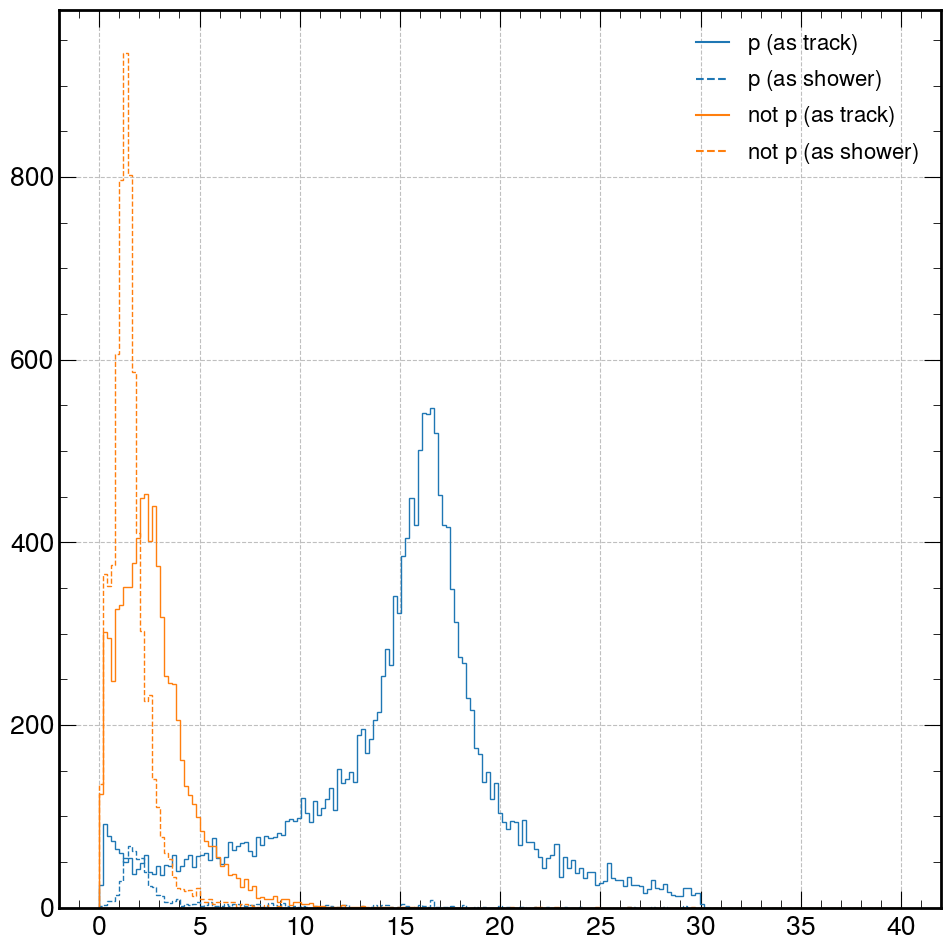

In [7]:
dftest = dfall

pnccut = 0.8
onlycontained=False
plot_pid(dftest.filter(pl.col('enu_truth')<0.3), 'B', threshold_pnc=pnccut, ShowersAndTracks=False, onlyShower=False, onlycontained=onlycontained, pdg=2212, label=' (as track)')
plot_pid(dftest.filter(pl.col('enu_truth')<0.3), 'B', threshold_pnc=pnccut, ShowersAndTracks=True,   onlyShower=True, onlycontained=onlycontained, pdg=2212, label=' (as shower)', ls='--', color='C0')
plot_pid(dftest.filter(pl.col('enu_truth')<0.3), 'B', threshold_pnc=pnccut, ShowersAndTracks=False, onlyShower=False, onlycontained=onlycontained, pdg=2212, label=' (as track)', notthispdg=True, color='C1')
plot_pid(dftest.filter(pl.col('enu_truth')<0.3), 'B', threshold_pnc=pnccut, ShowersAndTracks=True,   onlyShower=True, onlycontained=onlycontained, pdg=2212, label=' (as shower)', notthispdg=True, ls="--", color="C1")
# plt.yscale('log')


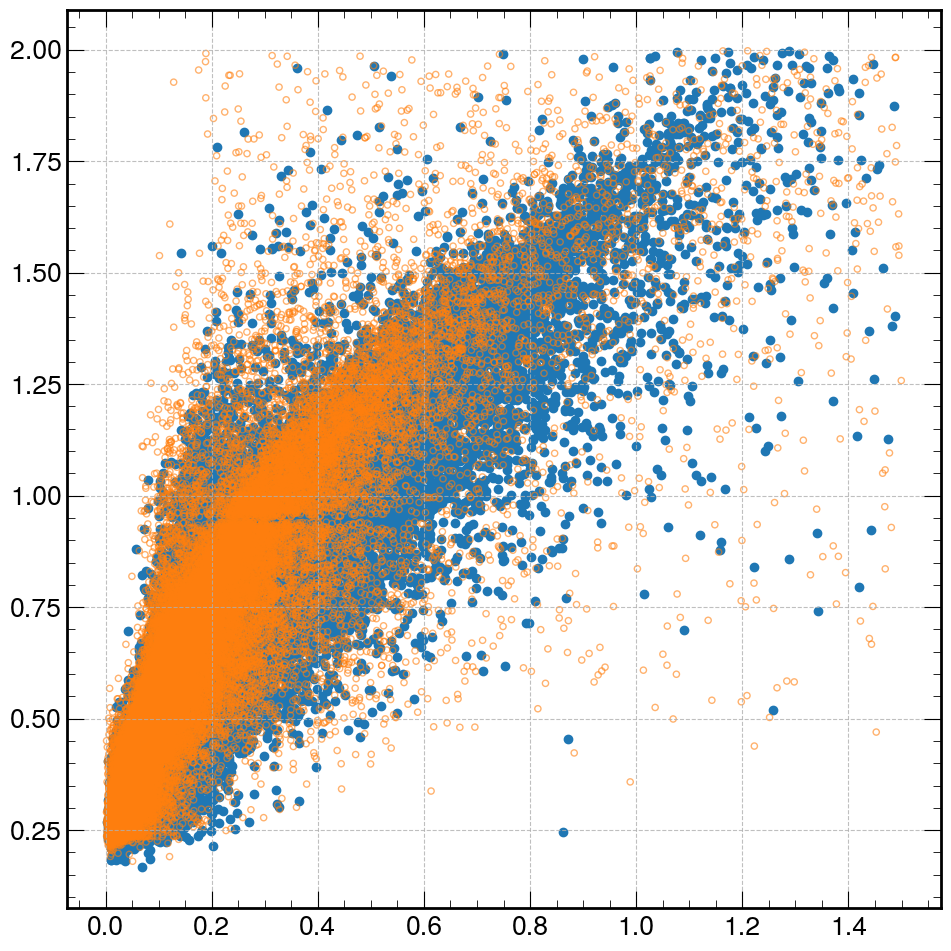

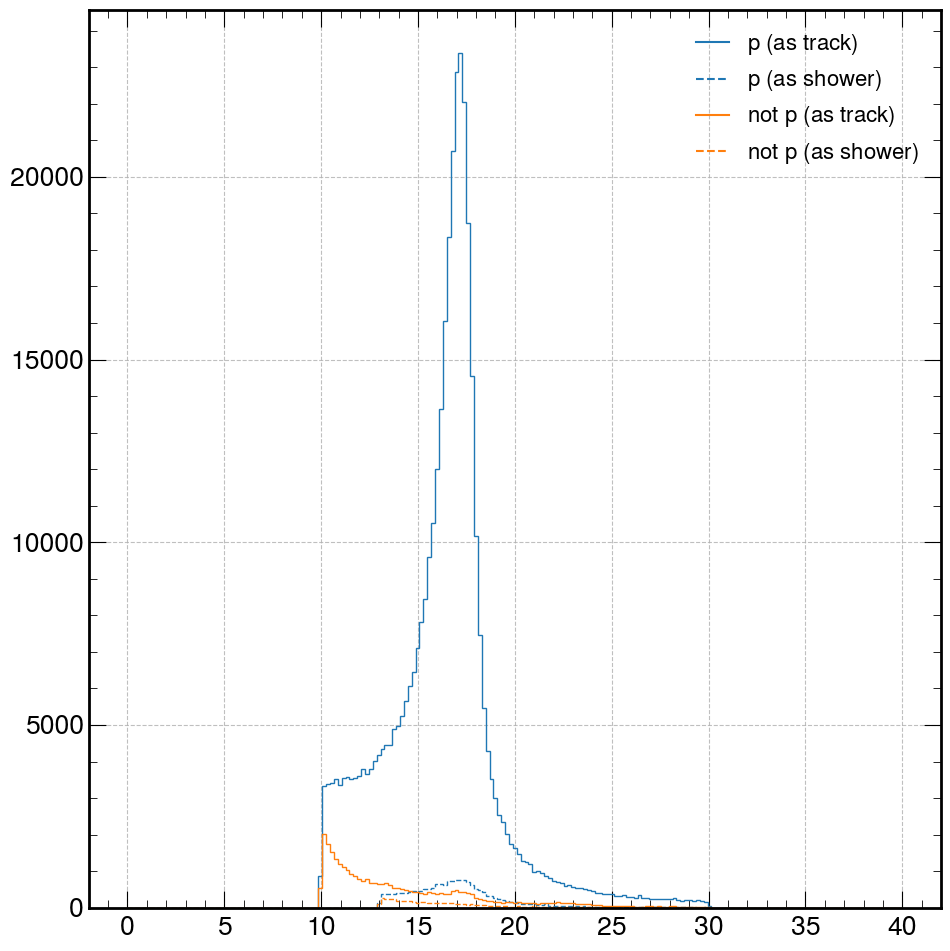

In [8]:
vy='trkmomrange_pr'
vx='trkcalo_planes_B'
binscalo = np.linspace(-0.1,0.5,200)
binsmomrange = np.linspace(0.2, 1, 100)
plt.figure()
dftestpr = create_proton_candidate(dftest, return_only_selected=True)
plt.scatter(dftestpr.filter(isproton()) [vx], dftestpr.filter(isproton())[vy])
plt.scatter(dftestpr.filter(~isproton())[vx], dftestpr.filter(~isproton())[vy], alpha=0.6, s=20, color="C1", facecolor='none')
# plt.xlim(0, 5)
# plt.ylim(0, 5)

plt.figure()
pnccut = 0.
onlycontained=False
plot_pid(dftestpr, 'B', threshold_pnc=pnccut, ShowersAndTracks=False, onlyShower=False, onlycontained=onlycontained, pdg=2212, label=' (as track)')
plot_pid(dftestpr, 'B', threshold_pnc=pnccut, ShowersAndTracks=True,   onlyShower=True, onlycontained=onlycontained, pdg=2212, label=' (as shower)', ls='--', color='C0')
plot_pid(dftestpr, 'B', threshold_pnc=pnccut, ShowersAndTracks=False, onlyShower=False, onlycontained=onlycontained, pdg=2212, label=' (as track)', notthispdg=True, color='C1')
plot_pid(dftestpr, 'B', threshold_pnc=pnccut, ShowersAndTracks=True,   onlyShower=True, onlycontained=onlycontained, pdg=2212, label=' (as shower)', notthispdg=True, ls="--", color="C1")
# plt.yscale('log')

In [9]:
def plot_purity_completeness_particle(df:pl.DataFrame,
                             type="purity",
                             binse=None,
                             label=None,
                             plotnevents=False,
                             minPnC = 0.8,
                             pdg=2212,
                             selection="selected_pr",
                             donotplot=False,
                             ):
    
    if minPnC == 0: 
        minPnC = -1e12
    df = df.filter(pl.col('pnc')>=minPnC)
    # find all existing protons...
    dfallpr = df.filter(isparticle(pdg), pl.col('pnc')>=minPnC)
    # dfallpr_unique = dfallpr.group_by(selection_events('trkg4id_planes_B')).agg(pl.len(), pl.all().last()).filter(pl.col('len')>=2)
    # print(len(dfallpr_unique), len(dfallpr), len(dfallpr_unique)/len(dfallpr))
    if not binse:
        binse = np.logspace(-1,2, 100)
    bnall, b = np.histogram(dfallpr['enu_truth'], bins=binse)
    bn, b = np.histogram(df.filter(pl.col(selection))['enu_truth'], bins=binse)

    bnfiltered, b = np.histogram(df.filter(pl.col(selection), isparticle(pdg))['enu_truth'], bins=binse)

    completeness = np.divide(bnfiltered, bnall, out=np.zeros_like(bnall, dtype=np.float64), where=bnall!=0)
    purity = np.divide(bnfiltered, bn, out=np.zeros_like(bn, dtype=np.float64), where=bn!=0)
    if type=="completeness":
        type='efficiency'
        val = completeness
    elif type=="purity":
        val = purity
    else:# type=="cnp":
        type = "P x C"
        val = purity*completeness

    if donotplot:
        return val, b
    plt.hist(b[:-1], b, weights=val, histtype='step', label=label);
    plt.ylabel(type.title())
    plt.xlabel('Neutrino energy [GeV]')
    plt.legend()
    ax = plt.gca()
    if plotnevents:
        ax2 = plt.twinx()

        ax2.hist(b[:-1], b, weights=bnall, alpha=0.2, log=False)
        ax2.set_ylabel(rf'# of  events')
        ax2.set_yscale('log')
        ax2.grid(False)
    plt.sca(ax)
    return val, b

<Figure size 1000x1000 with 0 Axes>

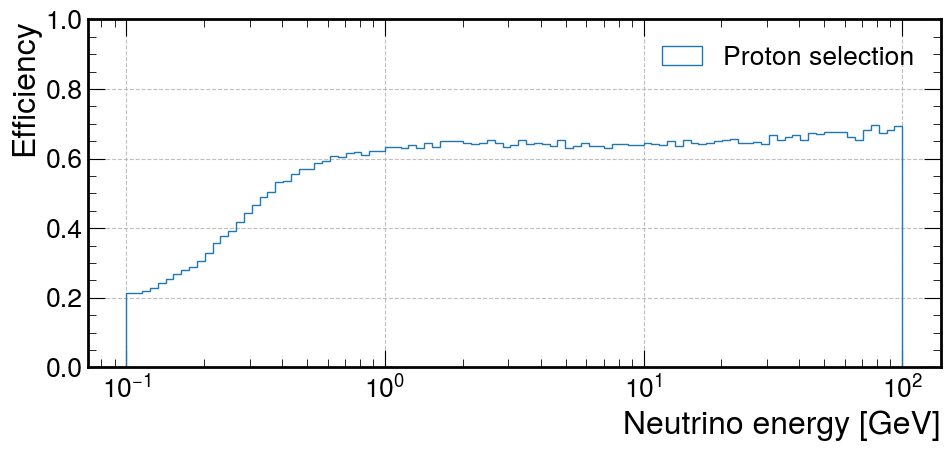

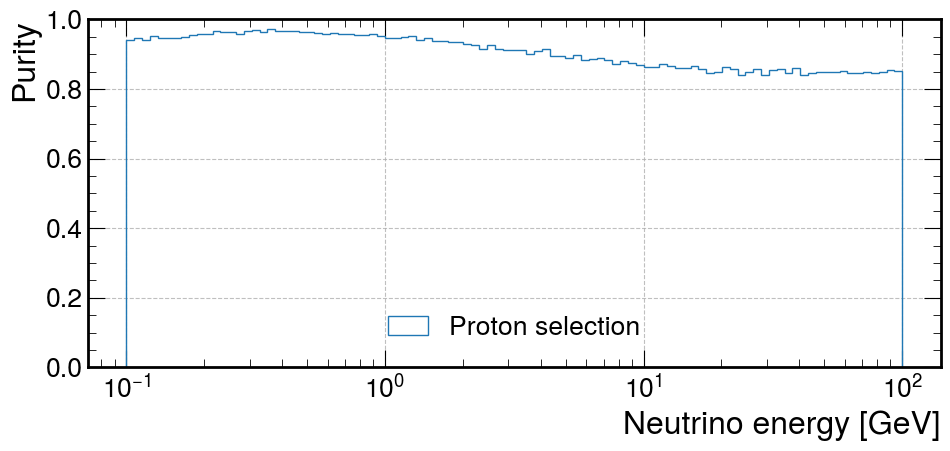

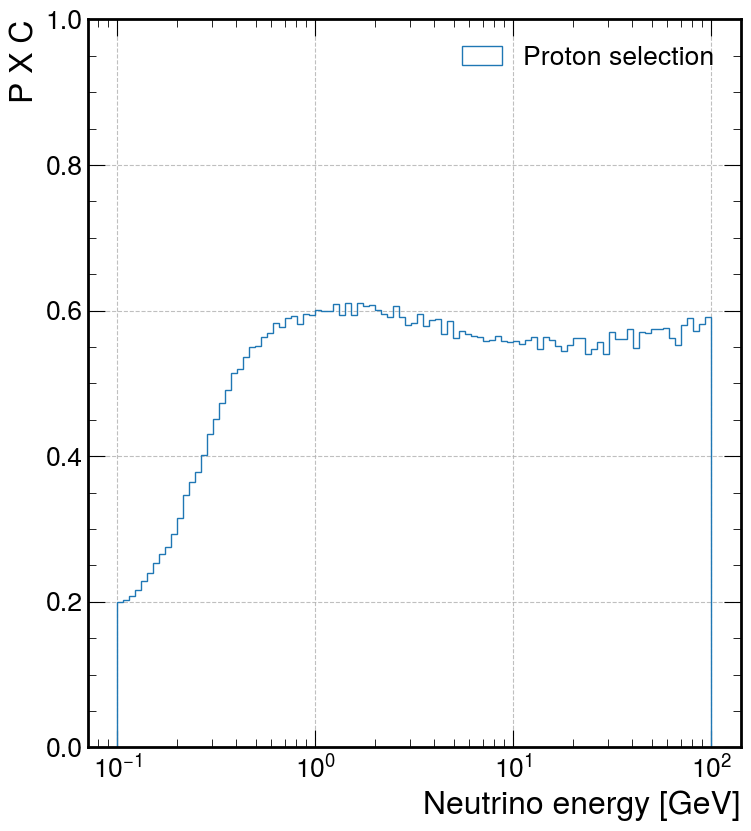

In [10]:
dftestpr = create_proton_candidate(dftest, return_only_selected=False)
plt.figure()
label='Proton selection'
extra="_nc"
minPnC = 0.
plt.figure(figsize=(10,5))
plot_purity_completeness_particle(dftestpr, type='completeness', label=label, minPnC=minPnC)
plt.ylim(0,1)
plt.xscale('log')
plt.savefig(f'graphs/proton_c{extra}.png', dpi=200)
plt.figure(figsize=(10,5))
plot_purity_completeness_particle(dftestpr, type='purity', label=label, minPnC=minPnC)
plt.ylim(0,1)
plt.xscale('log')
plt.savefig(f'graphs/proton_p{extra}.png', dpi=200)
plt.figure(figsize=(10*0.8,11*0.8))
v, b = plot_purity_completeness_particle(dftestpr, type='pnc', label=label, plotnevents=False, minPnC=minPnC)
plt.xscale('log')
plt.ylim(0,1)
plt.savefig(f'graphs/proton_pnc{extra}.png', dpi=200)

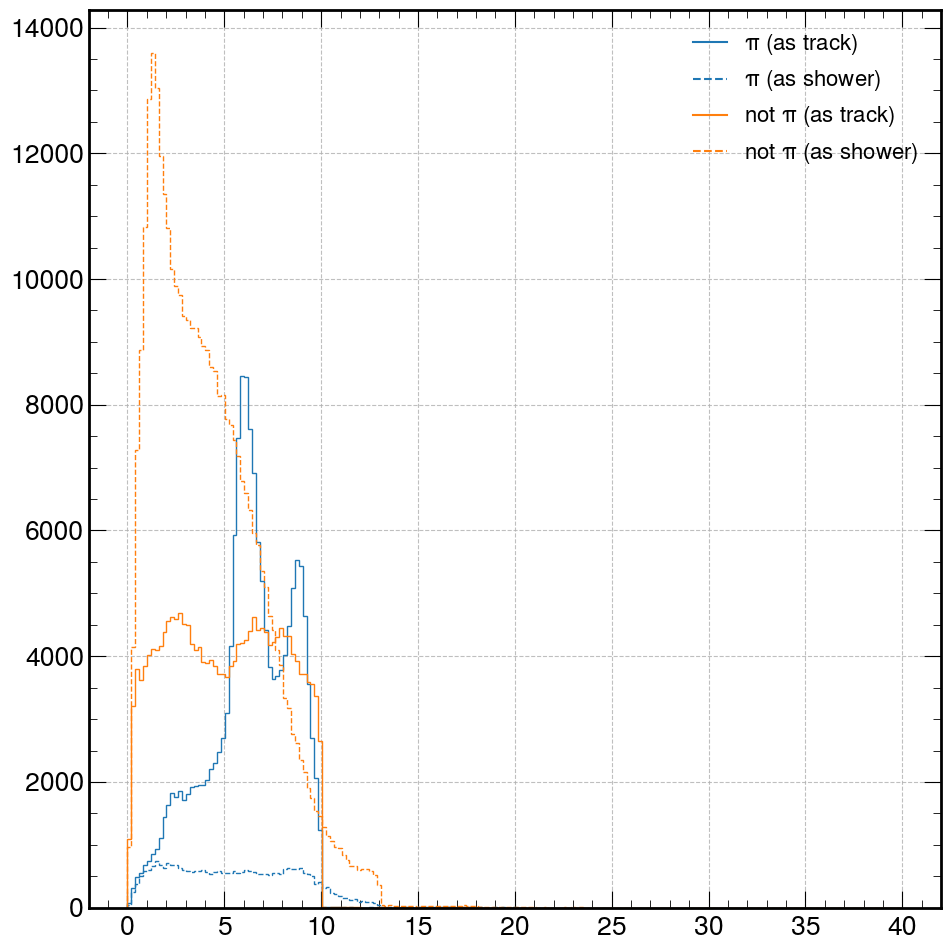

In [11]:
dftestpi = dftestpr.filter(~pl.col('selected_pr')) # removing here for a more precise purity and completeness

pnccut = 0.
onlycontained=True
plot_pid(dftestpi, 'B', threshold_pnc=pnccut, ShowersAndTracks=False, onlyShower=False, onlycontained=onlycontained, pdg=211, label=' (as track)')
plot_pid(dftestpi, 'B', threshold_pnc=pnccut, ShowersAndTracks=True,   onlyShower=True, onlycontained=onlycontained, pdg=211, label=' (as shower)', ls='--', color='C0')
plot_pid(dftestpi, 'B', threshold_pnc=pnccut, ShowersAndTracks=False, onlyShower=False, onlycontained=onlycontained, pdg=211, label=' (as track)', notthispdg=True, color='C1')
plot_pid(dftestpi, 'B', threshold_pnc=pnccut, ShowersAndTracks=True,   onlyShower=True, onlycontained=onlycontained, pdg=211, label=' (as shower)', notthispdg=True, ls="--", color="C1")
# plt.yscale('log')

<Figure size 1000x1000 with 0 Axes>

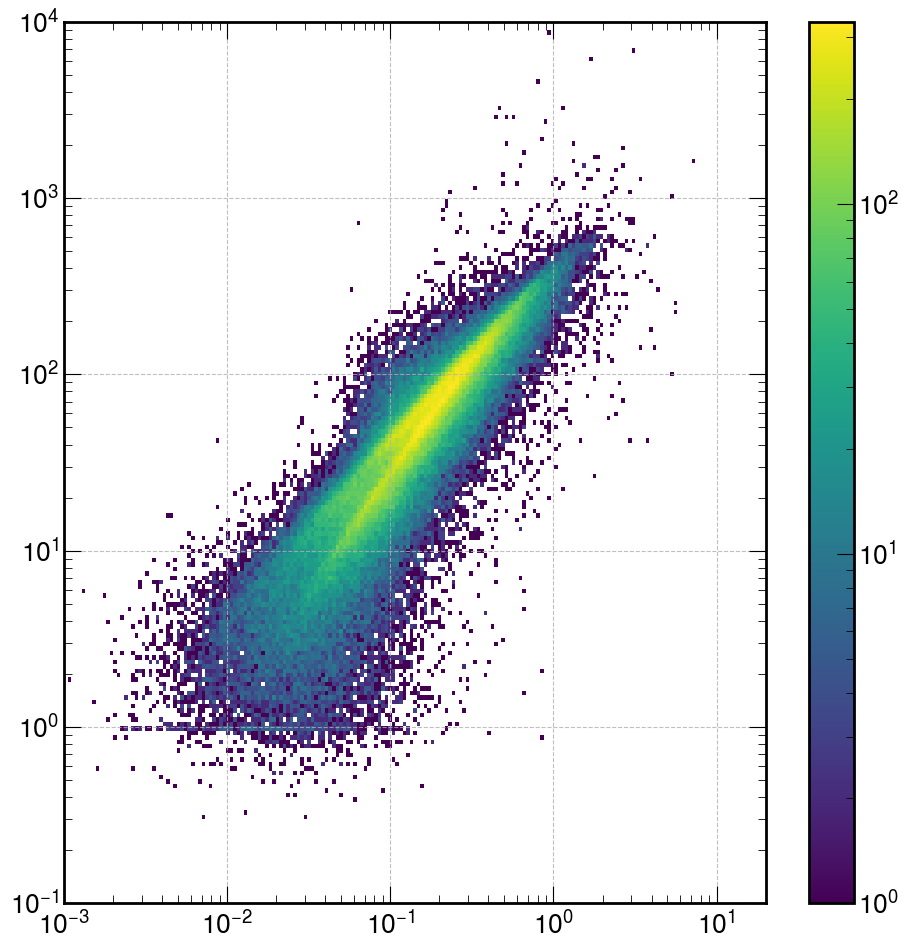

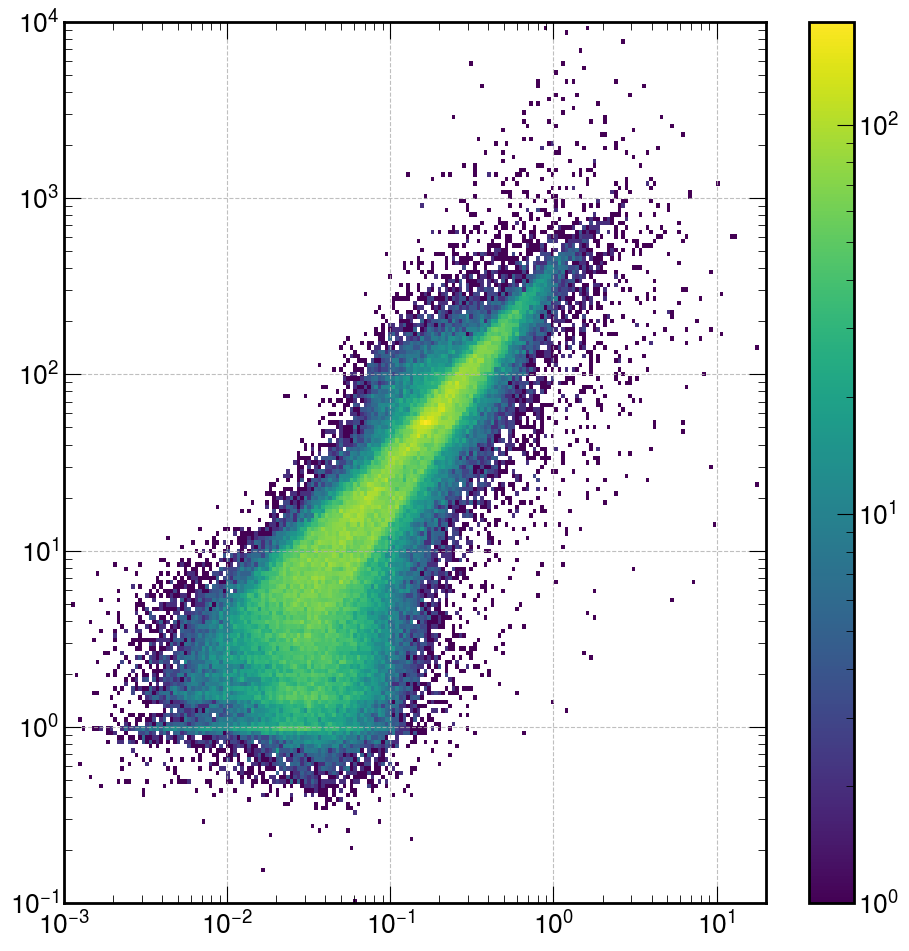

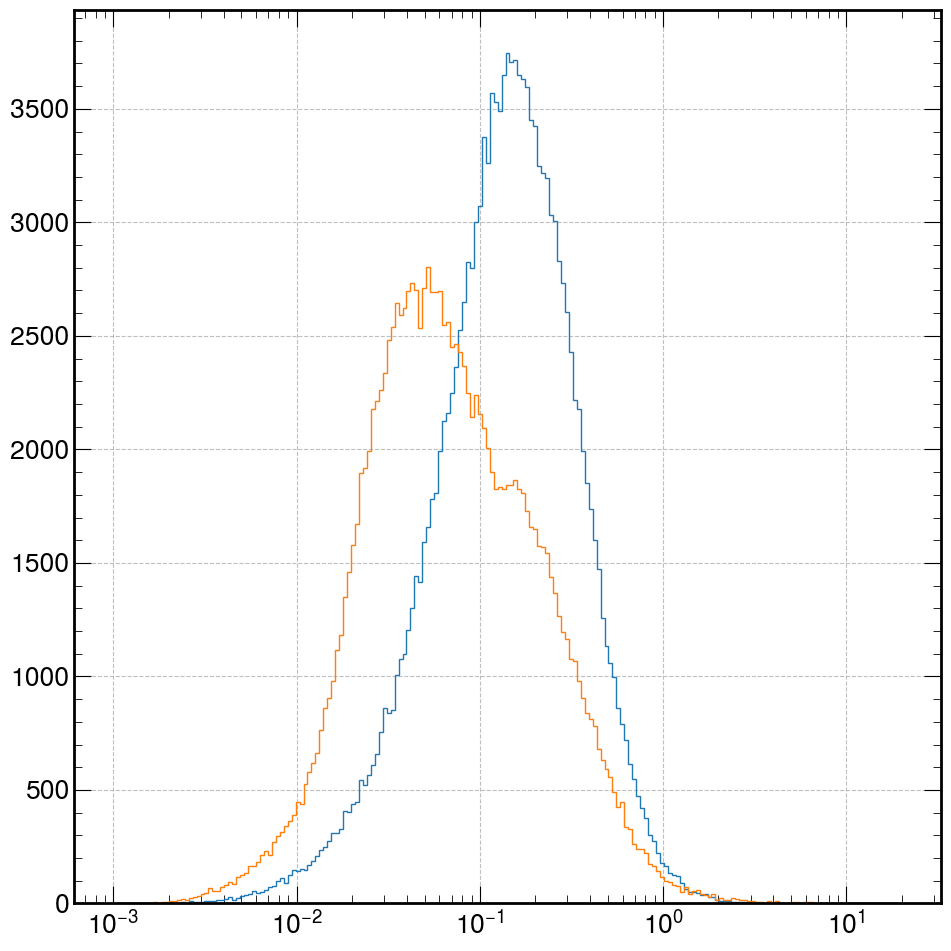

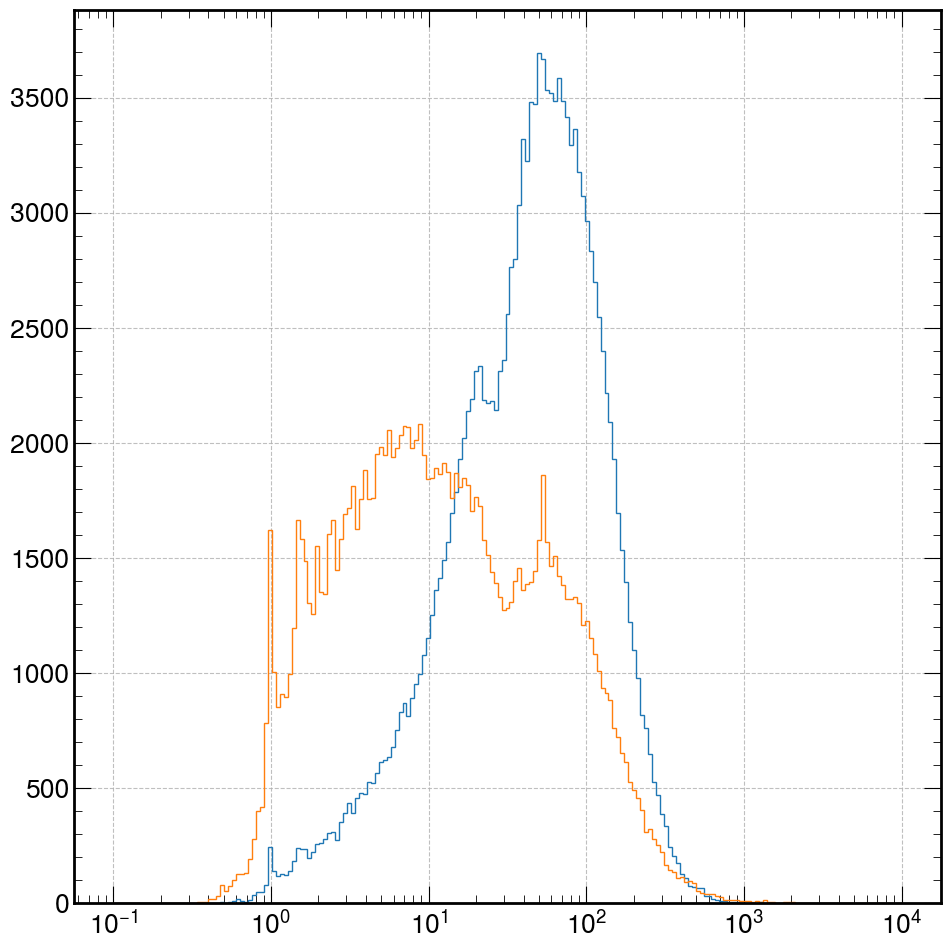

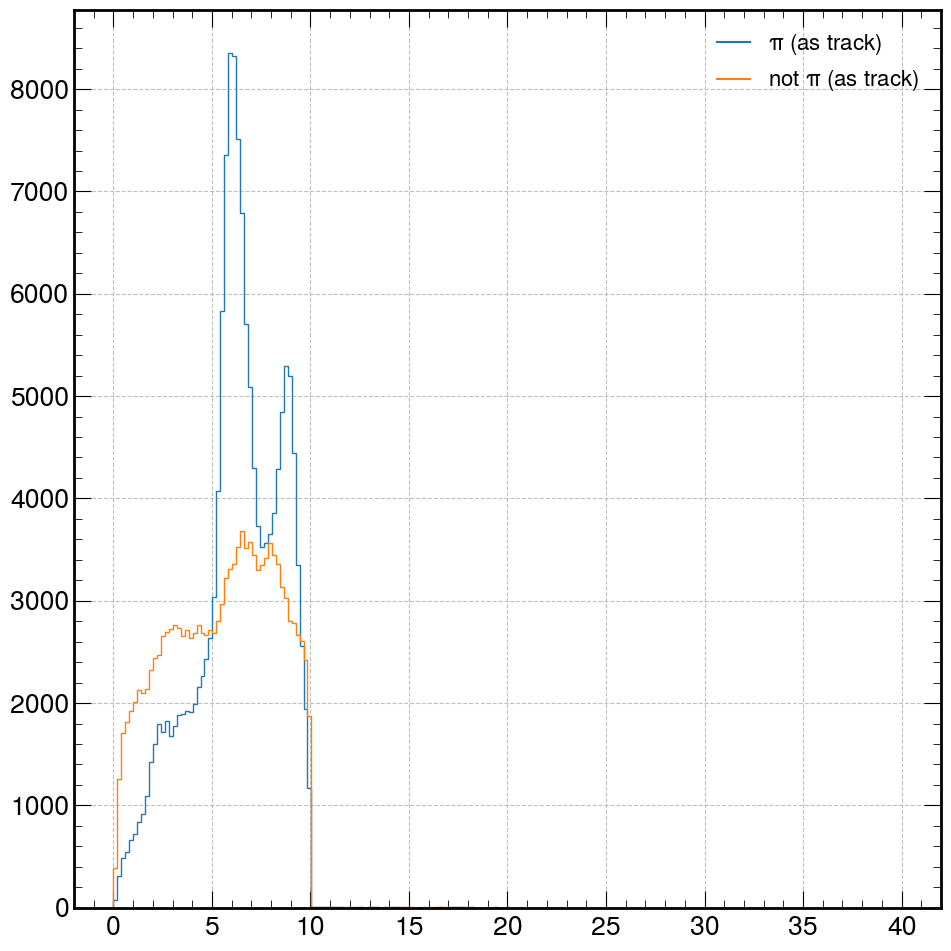

In [12]:
plt.figure()
minPnC=0.
dftest2 = create_pion_candidate(dftestpr, 
                                othercuts=False,
                                ).filter(
    True,
    pl.col('pnc')>minPnC,
    pl.col('trkIsContained')
).with_columns(
    trkg4mom_planes_B = (pl.col('trkg4en_planes_B')**2 - pl.col('trkg4mass_planes_B')**2).sqrt()
)
vy='trklen'
vx='trkcalo_planes_B'
binscalo = np.linspace(-0.1,15,200)
binscalo = np.logspace(-3,np.log10(20), 200)
binsmomrange = np.logspace(-1, 4, 200)
pdg=211

vmax=None
plt.figure()
plt.hist2d(dftest2.filter(isparticle(pdg)) [vx], dftest2.filter(isparticle(pdg))[vy], bins=[binscalo, binsmomrange], cmin=1, norm='log', vmax=vmax);
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.figure()
plt.hist2d(dftest2.filter(~isparticle(pdg)) [vx], dftest2.filter(~isparticle(pdg))[vy], bins=[binscalo, binsmomrange], cmin=1, norm='log', vmax=vmax);
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

plt.figure()
plt.hist(dftest2.filter(isparticle(pdg)) [vx], bins=binscalo, histtype='step')
plt.hist(dftest2.filter(~isparticle(pdg))[vx], bins=binscalo, histtype='step')
plt.xscale('log')
# plt.yscale('log')
plt.figure()
plt.hist(dftest2.filter(isparticle(pdg)) [vy], bins=binsmomrange, histtype='step')
plt.hist(dftest2.filter(~isparticle(pdg))[vy], bins=binsmomrange, histtype='step')
plt.xscale('log')
# plt.yscale('log')

plt.figure()
plot_pid(dftest2, 'B', threshold_pnc=pnccut, ShowersAndTracks=False, onlyShower=False, onlycontained=onlycontained, pdg=211, label=' (as track)')
plot_pid(dftest2, 'B', threshold_pnc=pnccut, ShowersAndTracks=False, onlyShower=False, onlycontained=onlycontained, pdg=211, label=' (as track)', notthispdg=True, color='C1')

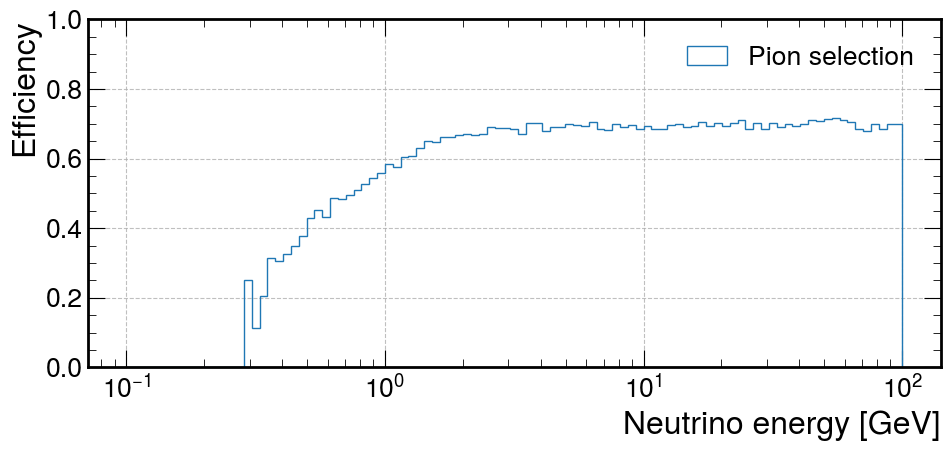

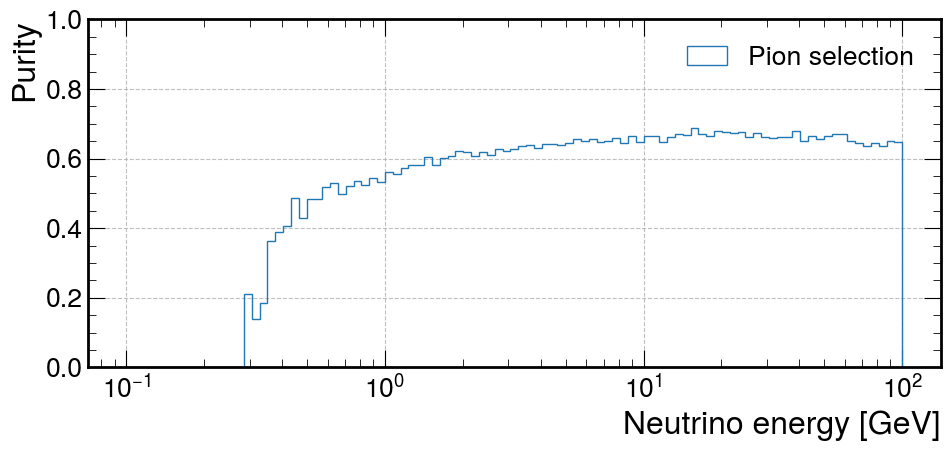

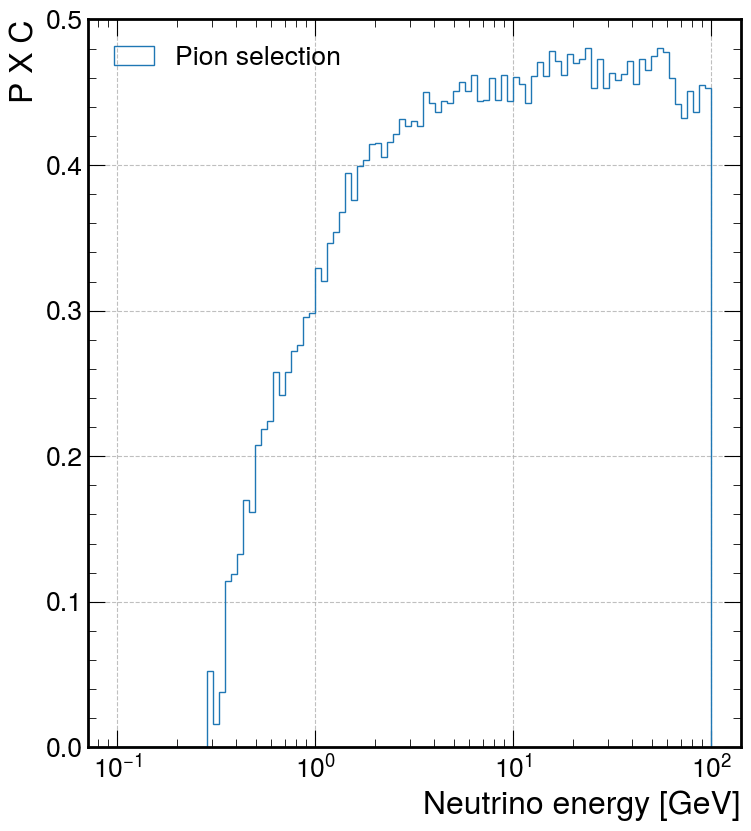

In [13]:
dftest = dfall
dftestpr = create_proton_candidate(dftest, return_only_selected=False)
dfprpiselected = create_pion_candidate(dftestpr, return_only_selected=False, lower_threshold_len=10)
dfmaxeffpi = create_pion_candidate(dftestpr, return_full_efficiency=True, return_only_selected=False)
# dfmaxeffpi = create_pion_candidate(dftestpr, lower_threshold_len=10, return_only_selected=False)
plt.figure(figsize=(10,5))
label='Pion selection'
extra="nc"
minPnC = 0.
pdg=211
dfprpiselected = dfprpiselected.filter(
    ~pl.col('selected_pr'),
#     (isparticle(211)) & (pl.col('rrkIsContained'))
)
plot_purity_completeness_particle(dfprpiselected, type='completeness', label=label, minPnC=minPnC, pdg=pdg, selection="selected_pi")
val, b = plot_purity_completeness_particle(dfmaxeffpi, type='completeness', label=label, minPnC=minPnC, pdg=pdg, selection="selected_pi", donotplot=True)
# plt.hist(b[:-1], b, weights=val, histtype='step', label='Maimum efficiency');
plt.ylim(0,1)
plt.legend()
plt.xscale('log')
plt.savefig(f'graphs/pion_c{extra}.png', dpi=200)
plt.figure(figsize=(10,5))
plot_purity_completeness_particle(dfprpiselected, type='purity', label=label, minPnC=minPnC, pdg=pdg, selection="selected_pi")
# plot_purity_completeness_particle(dfmaxeffpi, type='purity', label='Maximum efficiency', minPnC=minPnC, pdg=pdg, selection="selected_pi")
plt.xscale('log')
plt.ylim(0,1)
plt.savefig(f'graphs/pion_p{extra}.png', dpi=200)
plt.figure(figsize=(10*0.8,11*0.8))
v, b = plot_purity_completeness_particle(dfprpiselected, type='pnc', label=label, plotnevents=False, minPnC=minPnC, pdg=pdg, selection="selected_pi")
# plot_purity_completeness_particle(dfmaxeffpi, type='pnc', label='Maximum efficiency', minPnC=minPnC, pdg=pdg, selection="selected_pi")
plt.xscale('log')
plt.ylim(0,0.5)
plt.savefig(f'graphs/pion_pnc{extra}.png', dpi=200)

In [14]:
dfe = dfall.with_columns(
    enuvistruth = pl.col('enu_truth') - pl.col('lepen')
)
dfpr = create_proton_candidate(dfe, return_only_selected=False)
dfprpiselected = create_pion_candidate(dfpr, return_only_selected=False, lower_threshold_len=10)
dfprpiselected_selective = create_pion_candidate(dfpr, return_only_selected=False, lower_threshold_len=20)
dfcomplex_en = complex_energy_nc(dfprpiselected)
dfcomplex_en_selective = complex_energy_nc(dfprpiselected_selective)
dfcomplex_en_full = complex_energy_nc(dfprpiselected, return_full=True)
dfsimple_en = simple_energy_nc(dfall)
dfsimple_en_full = simple_energy_nc(dfall, return_full=True)

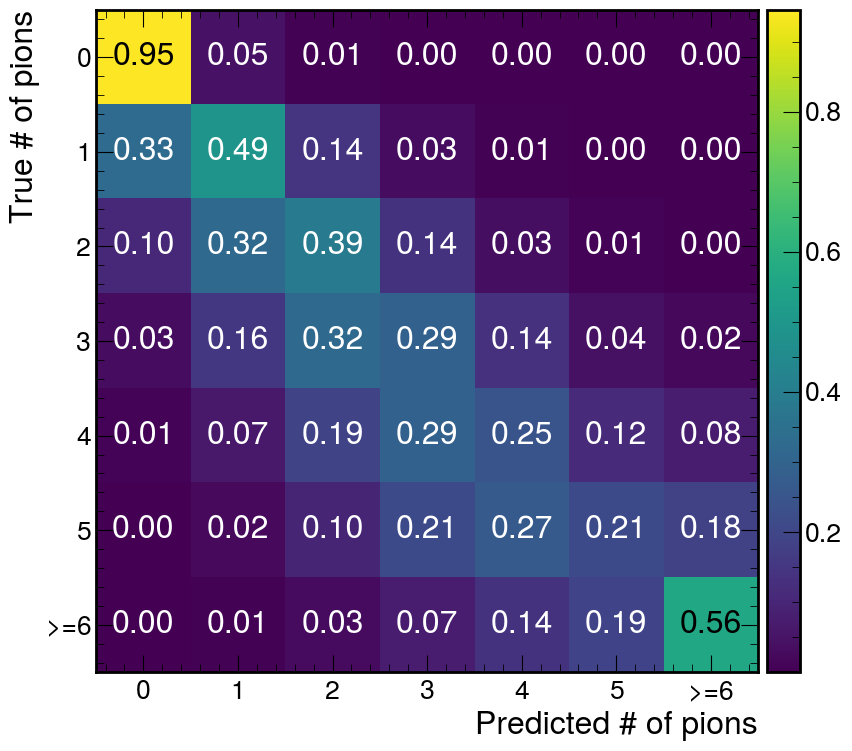

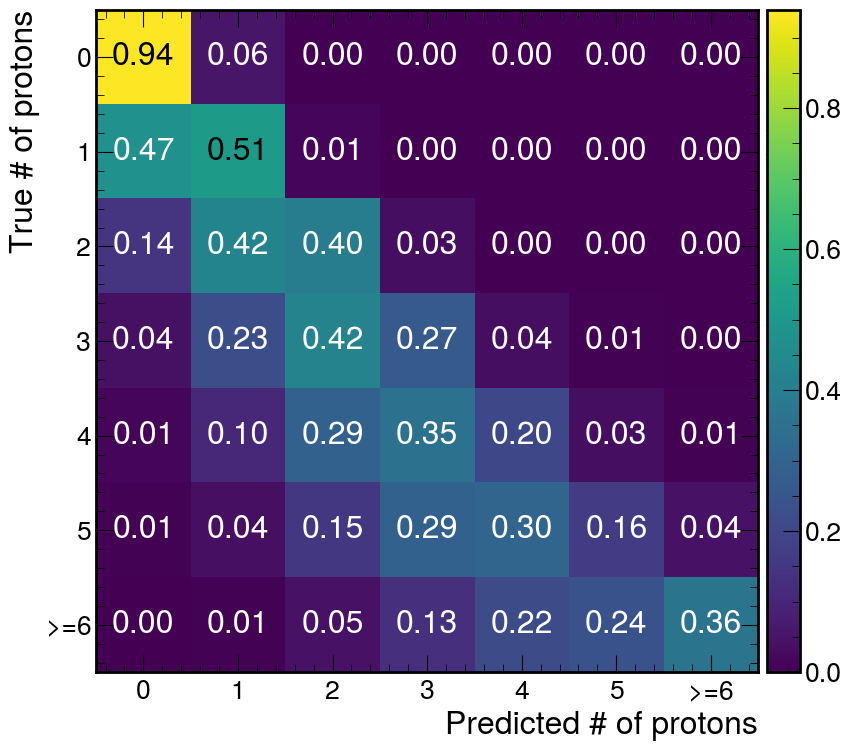

In [50]:

from sklearn import metrics
# dfmatches = dfprpiselected.filter(pl.col('trkPFPIsTrack')).group_by(selection_events(), maintain_order=True).agg(
minPNC=0
dfmatches = dfprpiselected.filter(
        pl.col('pnc') > minPNC
    ).group_by(selection_events(), maintain_order=True).agg(
    pl.col('selected_pi').filter(pl.col('selected_pi')).len().cast(pl.Int32).alias('npi'),
    pl.col('trkg4pdg_planes_B').filter(isparticle(211)).len().cast(pl.Int32).alias('npitruth'),
    pl.col('trkg4id_planes_B').filter(isparticle(211)).unique().len().alias('npitunique'),
    pl.col('selected_pr').filter(pl.col('selected_pr')).len().cast(pl.Int32).alias('npr'),
    pl.col('trkg4pdg_planes_B').filter(isparticle(2212)).len().cast(pl.Int32).alias('nprtruth'),
    pl.col('trkg4id_planes_B').filter(isparticle(2212)).unique().len().alias('nprtunique'),
    pl.col('enu_truth').last(),
    pl.col('lepen').last(),
).with_columns(
    ratio_pi = ( pl.col('npi')-pl.col('npitruth') ),
    ratio_pr = ( pl.col('npr')-pl.col('nprtruth') )
)

nmax=6
classes = [0,1,2,3,4,5,">=6"]
dfmatches = dfmatches.with_columns(
    pl.when(pl.col('npi')>nmax).then(nmax).otherwise(pl.col('npi')).alias('npi'),
    pl.when(pl.col('npitruth')>nmax).then(nmax).otherwise(pl.col('npitruth')).alias('npitruth'),
    pl.when(pl.col('npr')>nmax).then(nmax).otherwise(pl.col('npr')).alias('npr'),
    pl.when(pl.col('nprtruth')>nmax).then(nmax).otherwise(pl.col('nprtruth')).alias('nprtruth'),
)

confusion_matrix_pi = metrics.confusion_matrix(dfmatches['npitruth'], dfmatches['npi'])
# print(confusion_matrix_pi)
# print(confusion_matrix_pi.sum())
confusion_matrix_pi = np.array([ line/total for line, total in zip(confusion_matrix_pi, confusion_matrix_pi.sum(1))])
# print(confusion_matrix_pi)

fig, ax = plt.subplots(figsize=(10,8))
cb = ax.imshow(confusion_matrix_pi)
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
for i in range(len(classes)):
    for j in range(len(classes)):
        color='white' if confusion_matrix_pi[i,j] < 0.5 else 'black'
        # color='green' if confusion_matrix_pi.transpose()[j,i] < 0.5 else 'white'
        ax.annotate(f'{confusion_matrix_pi[i,j]:.2f}', (j,i), 
                    color=color, va='center', ha='center')
ax.grid(False)
plt.colorbar(cb, ax=ax, pad=0.01)
plt.ylabel('True # of pions')
plt.xlabel('Predicted # of pions')
plt.show()

confusion_matrix_pr = metrics.confusion_matrix(dfmatches['nprtruth'], dfmatches['npr'])
confusion_matrix_pr = np.array([ line/total for line, total in zip(confusion_matrix_pr, confusion_matrix_pr.sum(1))])

fig, ax = plt.subplots(figsize=(10,8))
cb = ax.imshow(confusion_matrix_pr)
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
for i in range(len(classes)):
    for j in range(len(classes)):
        color='white' if confusion_matrix_pr[i,j] < 0.5 else 'black'
        # color='green' if confusion_matrix_pr.transpose()[j,i] < 0.5 else 'white'
        ax.annotate(f'{confusion_matrix_pr[i,j]:.2f}', (j,i), 
                    color=color, va='center', ha='center')
ax.grid(False)
plt.colorbar(cb, ax=ax, pad=0.01)
plt.ylabel('True # of protons')
plt.xlabel('Predicted # of protons')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


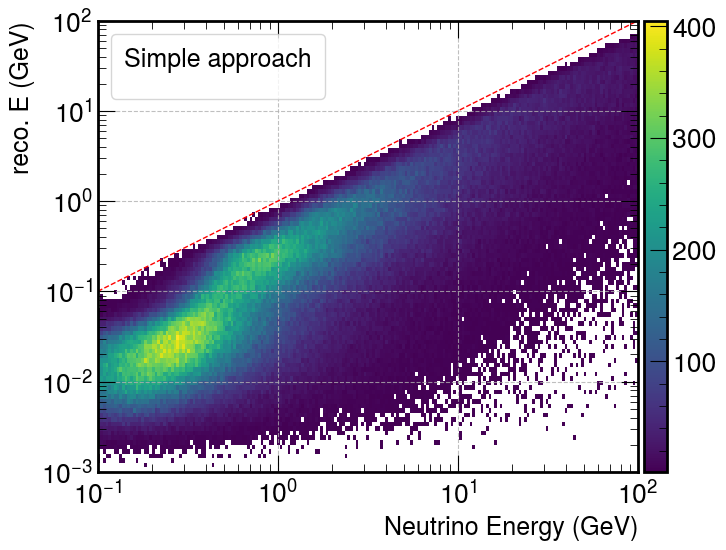

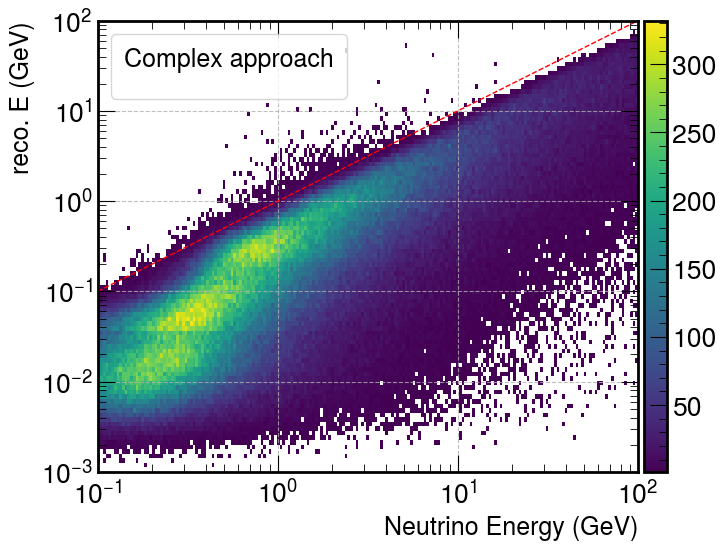

In [51]:
def plot_en_vs_en(Emu:pl.DataFrame,
                  lmethod,
                  x='enu_truth',
                  y='Etotal',
                  figsize=(8,6),
                  binsx=None,
                  binsy=None,
                  zscale='linear'
                  ):

    fig = plt.figure(figsize=figsize)
    if binsx is None:
        binsx = np.logspace(-1,2,200)
    if binsy is None:
        binsy = np.logspace(-1,2,200)
    # binsy = np.logspace(-1.1,np.log10(120),200)
    fontsize=18
    # fontsize='xx-large'
    plt.hist2d(Emu[x],Emu[y], bins=(binsx,binsy), norm=zscale, cmin=1, rasterized=True);
    # plt.plot([0,100],[0,100],'--', c='r')
    plt.xlabel('Neutrino Energy (GeV)', fontsize=fontsize)
    plt.ylabel(f'reco. E (GeV)', fontsize=fontsize)

    plt.yscale('log')
    plt.xscale('log')
    # plt.tick_params(labelsize=fontsize)

    cbar = plt.colorbar(pad=0.01)
    # cbar.ax.set_ylabel('# of events', fontsize=fontsize)
    
    if lmethod != '':
        legend = plt.legend(frameon=True, title=lmethod, loc='upper left', bbox_to_anchor=(0,0.1,1,0.9))
        plt.setp(legend.get_title(),fontsize=fontsize)
    plt.plot([0,100],[0,100], 'r--', lw=1)
    # dunestyle.Preliminary(x=0.45, y=0.93, ax=plt.gca(), fontsize="xx-large")


binse=None
# binse=np.logspace(np.log10(50),2,100)
binsereco = binse
binsereco = np.logspace(-3,2,100)
plot_en_vs_en(dfsimple_en, binsy=binsereco, binsx=binse, lmethod='Simple approach', zscale='linear')
plot_en_vs_en(dfcomplex_en, binsy=binsereco, binsx=binse, lmethod='Complex approach', zscale='linear')
# plot_en_vs_en(dfcomplex_en_2, binsy=binsereco, binsx=binse, lmethod='Complex approach', zscale='linear')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


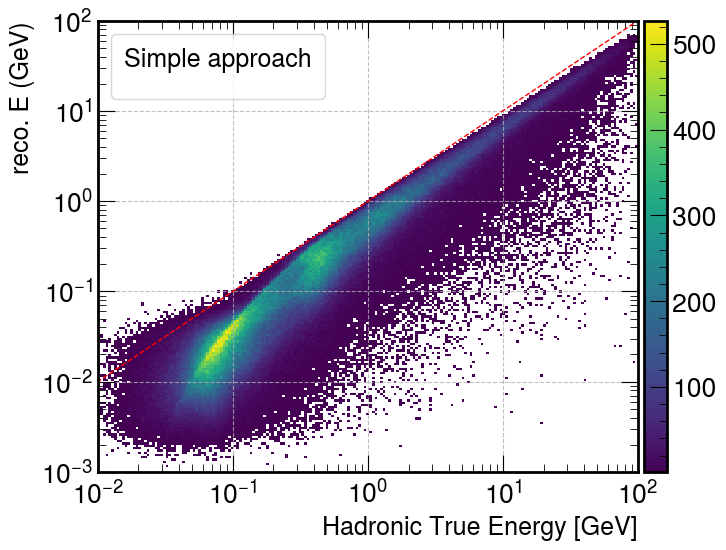

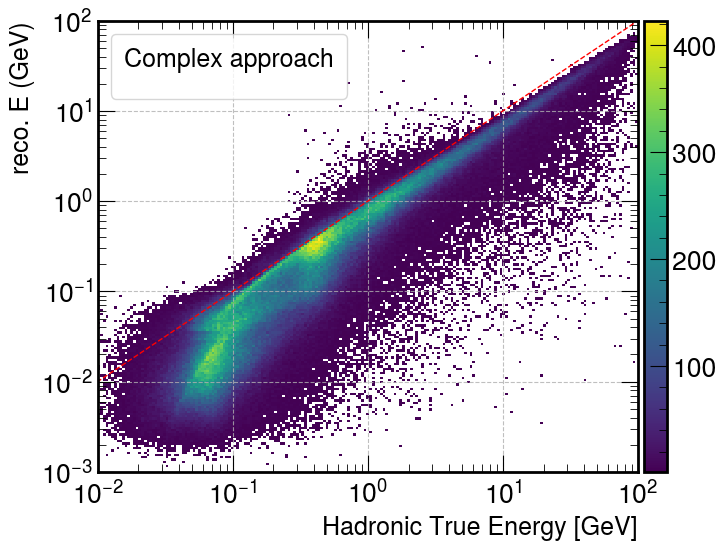

<Figure size 1000x1000 with 0 Axes>

In [52]:
binse=None
binse=np.logspace(-2,2,200)
binsereco = binse
binsereco=np.logspace(-3,2,200)
# binsereco = np.logspace(-1,2,100)
plot_en_vs_en(dfsimple_en, x='had_truth', y='Ehad', binsy=binsereco, binsx=binse, lmethod='Simple approach', zscale='linear')
plt.xlabel('Hadronic True Energy [GeV]')
plot_en_vs_en(dfcomplex_en, x='had_truth', y='Ehad', binsy=binsereco, binsx=binse, lmethod='Complex approach', zscale='linear')
plt.xlabel('Hadronic True Energy [GeV]')
plt.figure()
binse=np.logspace(-1.05,2,100)
binsereco = binse
# binsereco = np.logspace(-1,2,100)
# zscale='linear'
# plot_en_vs_en(dfsimple_en, x='lepen', y='Elep', binsy=binsereco, binsx=binse, lmethod='Simple approach', zscale=zscale)
# plt.xlabel('Muon True Energy [GeV]')
# plot_en_vs_en(dfcomplex_en, x='lepen', y='Elep', binsy=binsereco, binsx=binse, lmethod='Complex approach', zscale=zscale)
# plt.xlabel('Muon True Energy [GeV]')

In [53]:
from scipy.stats import binned_statistic
def plot_res_scatter(x,
                    y,
                    actualx = None,
                    binsx = np.logspace(-1,2,200),
                    xlabel = 'Neutrino Energy [GeV]',
                    ylabel = '',
                    makefrac = True,
                    fmt='.',
                    infotype='std',
                    xscale='log',
                    yscale='linear',
                    loc='best',
                    leg_ancor=None,
                    title='',
                    xpre = 0.3,
                    ypre = 0.93,
                    # titlesize='xx-large',
                    titlesize=None,
                    legendsize=None,
                    nolegend=False,
                    **kwargs):
    x = x.filter(y>0)
    y = y.filter(y>0)
    plotx = x.to_numpy()
    if not actualx is None:
        plotx = [v for v in actualx]
    if makefrac:
        ploty = (y/x-1).to_numpy()
        # ploty = (x/y-1).to_numpy()
        # plotx = plotx[y>0]
        # ploty = ploty[y>0]
    else:
        ploty = y
    if infotype=='std':
        val, _, _ = binned_statistic(plotx, ploty, manual_std, binsx)
        val*=100
        std, _, _ = binned_statistic(plotx, ploty, 'std', binsx)
        counts, _, _ = binned_statistic(plotx, ploty, 'count', binsx)
        val[counts<=2] = np.nan
        yerr = np.array([s*100/np.sqrt(2*c-1) if c>1 else 0 for s,c in zip(std,counts)])
        yerr = np.sqrt(yerr**2 + 0**2)
        if ylabel == '':
            ylabel = r'Resolution [%]'
        # if title=='':
        #     title = r'1$\sigma\times$100'
    else:
        val, _, _ = binned_statistic(plotx, ploty, infotype, binsx)
        std, _, _ = binned_statistic(plotx, ploty, 'std', binsx)
        counts, _, _ = binned_statistic(plotx, ploty, 'count', binsx)
        val[counts<=2] = np.nan
        yerr = [s/np.sqrt(c) if c>1 else 0 for s,c in zip(std,counts)]
        if ylabel == '':
            ylabel = r'$E_{reco}/E_{true}-1$'
        # if title=='':
        #     title = 'Mean'
    bins_center = 0.5*(binsx[:-1] + binsx[1:])
    bins_width = binsx[1:]- binsx[:-1]
    ax:plt.Axes
    ax = plt.gca()
    if 'capsize' in kwargs.keys():
        ax.errorbar(bins_center, val, xerr=(bins_width)/2, yerr=yerr, fmt=fmt, markersize=10, **kwargs)
    else:
        ax.plot(bins_center, val, fmt, **kwargs)
    plt.ylabel(ylabel,  )
    plt.xlabel(xlabel, )
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    if not nolegend:
        legend = plt.legend(frameon=True, fancybox=False, bbox_to_anchor=leg_ancor,title=title, loc=loc, title_fontsize=titlesize, fontsize=legendsize)
        legend.get_frame().set_edgecolor('k')
        legend.get_frame().set_linewidth(0.6)
    plt.xlim(binsx[0],binsx[-1])
    plt.sca(ax)
    # dunestyle.Preliminary(x=xpre, y=ypre, ax=plt.gca(), fontsize="xx-large")

/home/henrique/.local/lib/python3.10/site-packages/scipy/stats/_binned_statistic.py:609: RuntimeWarning: invalid value encountered in subtract
  delta = values[vv] - flatsum[binnumbers] / flatcount[binnumbers]
/home/henrique/.local/lib/python3.10/site-packages/scipy/stats/_binned_statistic.py:609: RuntimeWarning: invalid value encountered in subtract
  delta = values[vv] - flatsum[binnumbers] / flatcount[binnumbers]


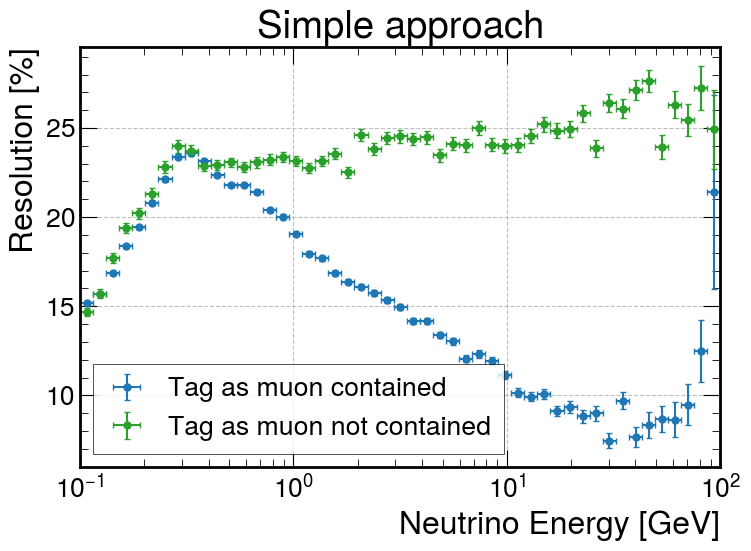

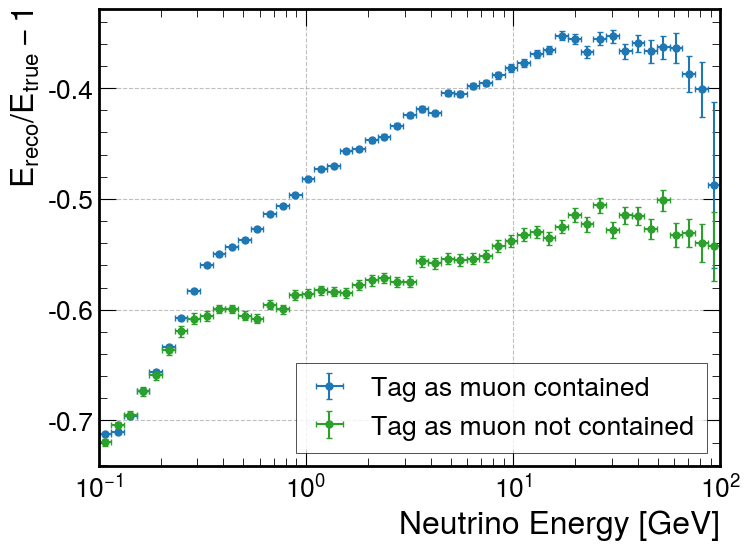

In [54]:

binsx= np.logspace(-1,2,50)
xscale='log'
capsize=2
label='LLHD'
plt.figure(figsize=(8,6))
x='had_truth'
y='Etotal'
plot_res_scatter(
    dfsimple_en.filter(pl.col('trkIsContained'))[x],
    dfsimple_en.filter(pl.col('trkIsContained'))[y],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="Tag as muon contained",
)
plot_res_scatter(
    dfsimple_en.filter(~pl.col('trkIsContained'))[x],
    dfsimple_en.filter(~pl.col('trkIsContained'))[y],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="Tag as muon not contained",
    color='C2'
)
# plt.savefig('graphs/simple_res.png')
# plt.ylim(0,60)
plt.title('Simple approach')

plt.figure(figsize=(8,6))
plot_res_scatter(
    dfsimple_en.filter(pl.col('trkIsContained'))[x],
    dfsimple_en.filter(pl.col('trkIsContained'))[y],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="Tag as muon contained",
    infotype='mean',
)
plot_res_scatter(
    dfsimple_en.filter(~pl.col('trkIsContained'))[x],
    dfsimple_en.filter(~pl.col('trkIsContained'))[y],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="Tag as muon not contained",
    infotype='mean',
    color='C2'
)

# plt.savefig('graphs/simple_bias.png')

In [55]:

def the_res_scatter(labels = None, infotype="std", *args, **kargs):
    commonargs = dict(
        binsx= np.logspace(-1,2,50),
        xscale='log',
        legendsize=16,
        titlesize=20,
        colorscontained=['C0','C1'],
        colorsnotcontained=['C2','C3'],
    )
    for k in commonargs.keys():
        if k not in kargs.keys():
            kargs[k] = commonargs[k]
    
    x='had_truth'
    y='Etotal'
    if 'x' in kargs.keys():
        x=kargs.pop('x')
    if 'y' in kargs.keys():
        y=kargs.pop('y')
    if labels is None:
        labels = [ i for i, _ in enumerate(args)]
    figsize = kargs.pop('figsize',(8,6))
    plts = []
    plts.append(plt.figure(figsize=figsize))
    thecolors_c = kargs.pop('colorscontained')
    thecolors_nc = kargs.pop('colorsnotcontained')
    if kargs.pop("no_color", False):
        thecolors_c = [ None for _ in labels ]
        thecolors_nc = [ None for _ in labels ]
    separated = kargs.pop("separated", False)
    nolegend = kargs.pop("nolegend", False)
    for df, label, c in zip(args, labels, thecolors_c):
        tlabel = f"{label}"
        title=''
        if separated:
            tlabel = label
            title = ''
        plot_res_scatter(
            df[x],
            df[y],
            label=tlabel,
            infotype=infotype,
            color=c,
            title=title,
            nolegend=nolegend,
            **kargs,
        )
    return plts



/home/henrique/.local/lib/python3.10/site-packages/scipy/stats/_binned_statistic.py:609: RuntimeWarning: invalid value encountered in subtract
  delta = values[vv] - flatsum[binnumbers] / flatcount[binnumbers]
/home/henrique/.local/lib/python3.10/site-packages/scipy/stats/_binned_statistic.py:609: RuntimeWarning: invalid value encountered in subtract
  delta = values[vv] - flatsum[binnumbers] / flatcount[binnumbers]


[<Figure size 800x600 with 1 Axes>]

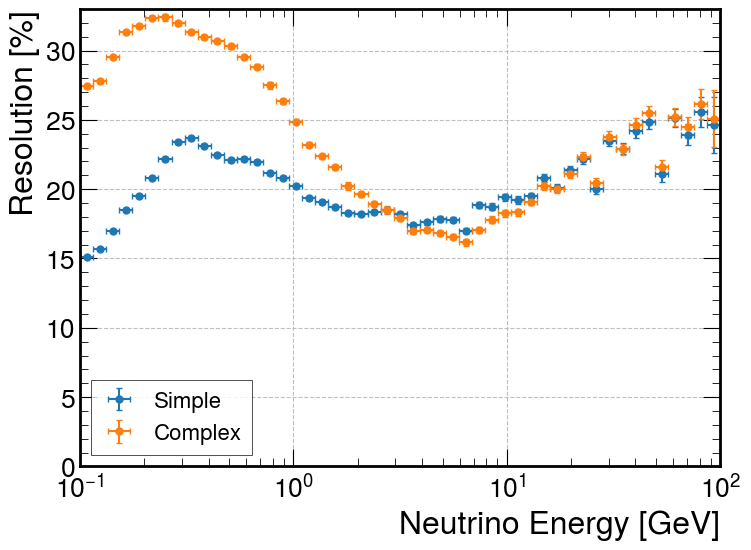

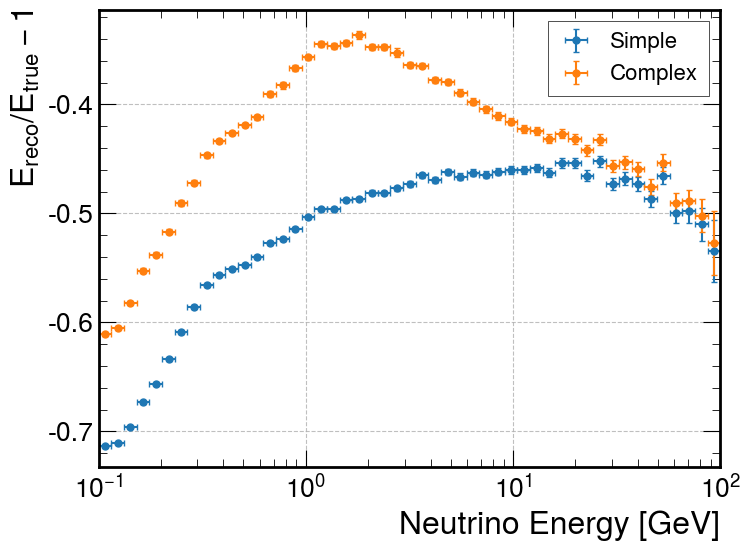

In [56]:
commonargs = dict(
    binsx= np.logspace(-1,2,50),
    xscale='log',
    capsize=2,
)
extra=""
the_res_scatter(["Simple","Complex"], "std", dfsimple_en, dfcomplex_en, **commonargs)
plt.ylim(0,33)
# plt.savefig(f'graphs/nc/nc_res{extra}.png')
the_res_scatter(["Simple","Complex"], "mean", dfsimple_en, dfcomplex_en, **commonargs)
# plt.ylim(-0.7,0)
# plt.savefig(f'graphs/nc/nc_bias{extra}.png')

In [15]:
dfsimple = 0
dfsimple_en = 0
dfe = 0
dfprselected = 0
dfprpiselected = 0
dfcomplex_en = 0
def process_data(dfall:pl.DataFrame, cheatpi = False, cheatpr = False, minPNC=0.0, saveit=True):
    global dfsimple
    global dfsimple_en
    global dfe
    global dfprselected
    global dfprpiselected
    global dfcomplex_en
    dfsimple_en = simple_energy_nc(dfall)
    dfe = dfall
    dfprselected = create_proton_candidate(dfe, cheat=cheatpi, cheatMinPNC=minPNC, return_only_selected=False)
    dfprpiselected = create_pion_candidate(dfprselected, cheat=cheatpr, cheatMinPNC=minPNC, lower_threshold_len=20, return_only_selected=False)
    dfcomplex_en = complex_energy_nc(dfprpiselected, W="W")
    if not saveit:
        return

    dfsimple_en.select(
        dfcomplex_en.drop('Kpi', 'Kpr', 'OtherPFPs', 'mass_to_add').columns
    ).write_parquet("./data/processed/nc/simple.parquet")
    complexname = "complex"
    if cheatpi or cheatpr:
        complexname+="_cheat"
    if cheatpi:
        complexname+="_pi"
    if cheatpr:
        complexname+="_pr"
    dfcomplex_en.write_parquet(f"./data/processed/nc/{complexname}.parquet")
    complexname

minPNC=0.
from itertools import product
possibles = [True, False]
res = product(possibles, repeat=2)
for docheats in res:
    c_pi = docheats[0]
    c_pr = docheats[1]
    process_data(dfall, cheatpi=c_pi, cheatpr=c_pr, minPNC=minPNC )

run,subrun,event,nuPDG_truth,ccnc_truth,mode_truth,nuWeight_truth,enu_truth,vtxx_truth,vtxy_truth,vtxz_truth,recovtxx,recovtxy,recovtxz,lepen,lepmass,leppdg,lepid,ntracks,trkId,trkstartx,trkstarty,trkstartz,trkendx,trkendy,trkendz,trkpurity,trkcompleteness,trkg4id,trkg4pdg,trkg4en,trkg4mass,trkg4mother,trknhits,trkg4id_planes_U,trkg4id_planes_V,trkg4id_planes_W,…,trkpidpida_W,allcalo_planes_U,allcalo_planes_V,allcalo_planes_W,nallhits_planes_U,nallhits_planes_V,nallhits_planes_W,otherallcalo_planes_U,otherallcalo_planes_V,otherallcalo_planes_W,othernallhits_planes_U,othernallhits_planes_V,othernallhits_planes_W,trkg4id_planes_B,trkg4pdg_planes_B,trkg4en_planes_B,trkg4mass_planes_B,trkg4mother_planes_B,trkpurity_planes_B,trkcompleteness_planes_B,trknhits_planes_B,trknhitsmatch_planes_B,trkcalo_planes_B,trktotalen_planes_B,trkpartialen_planes_B,trkpidchi2ndf_B,trkpidchi2pr_B,trkpidchi2ka_B,trkpidchi2pi_B,trkpidchi2mu_B,trkpidndf_B,trkpidpida_B,allcalo_planes_B,nallhits_planes_B,otherallcalo_planes_B,othernallhits_planes_B,pnc
i32,i32,i32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,i32,i16,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,f32,f32,i32,i32,i32,i32,i32,…,f32,f32,f32,f32,i32,i32,i32,f32,f32,f32,i32,i32,i32,i32,i32,f32,f32,i32,f32,f32,i32,i32,f32,f32,f32,i32,f32,f32,f32,f32,i32,f32,f32,i32,f32,i32,f32
1497,1,38605,12,1,2,5.4330128e7,2.208488,-34.97567,-569.725891,1011.935547,-34.931683,-569.140564,1012.044495,0.602483,0.0,12,4,6,4,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.4,0.5,2,2212,1.002051,0.938272,0,10,2,11,-1,…,-1.0,0.505357,0.498771,0.545761,236,337,308,0.046484,0.047696,0.058867,64,68,59,11,211,0.227414,0.13957,0,0.666667,0.093023,6,4,0.012205,-9999.0,-9999.0,-1,-1.0,-1.0,-1.0,-1.0,-1,-1.0,0.498771,337,0.047696,68,0.062016
1497,1,38606,-12,1,0,2.2578156e7,0.225081,-216.921204,224.798615,39.062595,-215.256073,222.814529,39.721603,0.167858,0.0,-12,5,1,0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,1.0,1.0,4,2212,0.988214,0.938272,0,12,4,4,4,…,-1.0,0.02712,0.029758,0.02855,12,13,10,0.00737,0.007216,0.007882,8,8,7,4,2212,0.988214,0.938272,0,1.0,1.0,5,5,0.022542,-9999.0,-9999.0,-1,-1.0,-1.0,-1.0,-1.0,-1,-1.0,0.029758,13,0.007216,8,1.0
1497,1,38614,12,1,2,2.7842914e7,11.809024,224.452469,35.055347,492.442871,224.634949,34.993084,492.325775,3.670432,0.0,12,4,10,8,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.952381,0.010599,5889,22,2.148996,3.0518e-8,5573,21,5889,5889,5889,…,-1.0,3.866447,4.63963,6.053281,1762,2383,1659,0.645839,0.272553,0.326045,381,262,229,5889,22,2.148996,3.0518e-8,5573,1.0,0.009368,8,8,0.016308,-9999.0,-9999.0,-1,-1.0,-1.0,-1.0,-1.0,-1,-1.0,4.63963,2383,0.645839,381,0.009368
1497,1,38615,14,1,10,4.6366428e7,0.42105,-310.115662,-318.928375,1318.342285,-309.87204,-319.289948,1318.304443,0.190861,0.0,14,4,2,1,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.75,0.75,5,2212,0.956811,0.938272,2,8,5,5,-1,…,-1.0,0.11435,0.114164,0.117339,34,46,40,0.008374,0.007843,0.009718,10,9,7,5,2212,0.956811,0.938272,2,0.6,1.0,5,3,0.007063,-9999.0,-9999.0,-1,-1.0,-1.0,-1.0,-1.0,-1,-1.0,0.114164,34,0.008374,10,0.6
1497,1,38618,16,1,0,5.5668976e7,2.890666,-292.82782,23.423157,771.296448,-293.308075,24.361967,771.202393,2.789562,0.0,16,5,1,0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.818182,0.818182,4,2212,0.980647,0.938272,0,11,4,4,-1,…,-1.0,0.025825,0.028768,0.029599,15,15,13,0.006813,0.009152,0.029599,8,11,13,4,2212,0.980647,0.938272,0,0.714286,1.0,7,5,0.019012,-9999.0,-9999.0,-1,-1.0,-1.0,-1.0,-1.0,-1,-1.0,0.028768,15,0.029599,13,0.714286
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
50538503,1,83442,14,1,2,1.9050534e7,91.049225,-292.14267,-18.352497,728.095398,-292.206818,-18.392855,727.996033,53.52367,0.0,14,4,20,0,-259.149231,562.496887,1249.194458,-309.139465,-777.969116,1340.736206,0.19401,0.628998,3,22,8.69797,0.0,0,16927,3,3,21764,…,-1.0,21.252449,20.666006,28.119982,9273,9436,8